# Домашнее задание к лекции «Поиск выбросов и генерация новых признаков»
## Задание к домашней работе

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
target = train['SalePrice']
train.drop(columns=['Id', 'SalePrice'], inplace=True)
train.shape

(1460, 79)

Смотрим процентное соотношение пропусков в колонках

In [4]:
for col in train.columns:
    pct_missing = train[col].isnull().mean()
    if pct_missing > 0:
        print(f'{col} - {pct_missing :.1%}')

LotFrontage - 17.7%
Alley - 93.8%
MasVnrType - 0.5%
MasVnrArea - 0.5%
BsmtQual - 2.5%
BsmtCond - 2.5%
BsmtExposure - 2.6%
BsmtFinType1 - 2.5%
BsmtFinType2 - 2.6%
Electrical - 0.1%
FireplaceQu - 47.3%
GarageType - 5.5%
GarageYrBlt - 5.5%
GarageFinish - 5.5%
GarageQual - 5.5%
GarageCond - 5.5%
PoolQC - 99.5%
Fence - 80.8%
MiscFeature - 96.3%


In [13]:
#Находим категориальные признаки
cat_feat = ['MSSubClass'] + list(train.dtypes[train.dtypes == object].index) # добавляем еще MSSubClass

In [14]:
#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
train[cat_feat] = train[cat_feat].fillna('nan')

In [15]:
#отфильтруем непрерывные признаки
num_feat = [f for f in train if f not in cat_feat]

In [16]:
# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = train[cat_feat].nunique()
print(cat_nunique)

MSSubClass       15
MSZoning          5
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       4
Functional        7
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            4
Fence             5
MiscFeature       5
SaleType          9
SaleCondition     6
dtype: int64


Отбрасывать категориальные признаки не будем

In [17]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(train[cat_feat], columns=cat_feat)
dummy_train.shape

(1460, 283)

In [19]:
# Заменяем пропуски в непрерывных признаках на специальное значение -999, чтобы деревья могли их отличить
X = pd.concat([train[num_feat].fillna(-999), dummy_train], axis=1)
y = target

### Строим отдельный hold-out датасет

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

На train обучаем модель и проводим кросс-валюдацию

Тест - это hold-out датасет для валидации модели 2-го уровня

### Построим случайный лес

In [100]:
from sklearn.ensemble import RandomForestRegressor

clf_rf = RandomForestRegressor(n_estimators=20, max_depth=20, min_samples_leaf=10, n_jobs=-1)
clf_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=10, n_estimators=20,
                      n_jobs=-1)

### Используем 10-fold кросс-валидацию для оценки качества модели дерева решений

In [101]:
from sklearn.model_selection import cross_val_score

In [102]:
model_cv_score = cross_val_score(clf_rf,
                X_train, y_train, 
                cv = 10)
model_cv_score

array([0.81296444, 0.75512899, 0.88803915, 0.8750312 , 0.69115659,
       0.86143429, 0.81980364, 0.75340958, 0.77266874, 0.91099081])

In [103]:
# среднее качество модели по фолдам
model_cv_score.mean()

0.8140627425188643

проверяем RandomForestRegressor на hold-out датасете

In [104]:
clf_rf.score(X_test, y_test)

0.8117561025520079

Валидация на hold-out датасете показала такое же качество, как и при кросс-валидации

In [105]:
imp = pd.DataFrame({'column': np.array(X_train.columns), 'feature_importance' : clf_rf.feature_importances_})
imp = imp.sort_values('feature_importance', ascending=False).head(10)
imp

,column,feature_importance
2,OverallQual,0.597193
14,GrLivArea,0.119647
11,1stFlrSF,0.059140
10,TotalBsmtSF,0.039359
17,FullBath,0.033897
1,LotArea,0.029219
7,BsmtFinSF1,0.023773
21,TotRmsAbvGrd,0.023029
25,GarageArea,0.013327
12,2ndFlrSF,0.006412


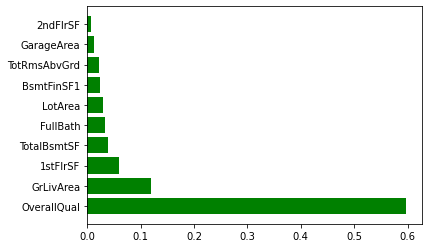

In [106]:
plt.barh(np.arange(len(imp)), imp.feature_importance, color='g');
plt.yticks(np.arange(len(imp)), imp.column);

### Обучить стекинг 3х моделей c двумя линейными моделями и 1 нелинейной

In [107]:
from sklearn.ensemble import StackingRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression

In [110]:
regressor = StackingRegressor( cv=10, 
                              estimators= [
        ('lr', LinearRegression()),
        ('svr', LinearSVR(random_state=42)),
        ('rfr', RandomForestRegressor(n_estimators=20, max_depth=20, min_samples_leaf=10, n_jobs=-1)),
                              ],
                              final_estimator=LinearRegression())

In [111]:
regressor.fit(X_train, y_train)

StackingRegressor(cv=10,
                  estimators=[('lr', LinearRegression()),
                              ('svr', LinearSVR(random_state=42)),
                              ('rfr',
                               RandomForestRegressor(max_depth=20,
                                                     min_samples_leaf=10,
                                                     n_estimators=20,
                                                     n_jobs=-1))],
                  final_estimator=LinearRegression())

Валидация все моделей стекинга на hold-out датасете 

In [112]:
for model in regressor.named_estimators_.keys():
    print(model, '\n', regressor.named_estimators_[model].score(X_test, y_test), '\n')
print("STACK", '\n', regressor.score(X_test, y_test))

lr 
 0.7047500673580027 

svr 
 0.48051275659676884 

rfr 
 0.8080377778593981 

STACK 
 0.783386558841017


In [113]:
regressor.final_estimator_.coef_

array([0.60402196, 0.06310318, 0.37202058])

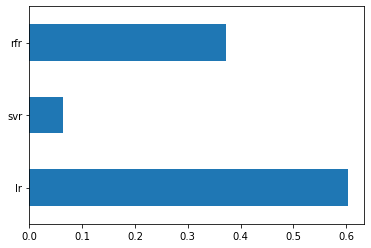

In [114]:
pd.Series(regressor.final_estimator_.coef_.flatten(), index=regressor.named_estimators_.keys()).plot(kind='barh')

Получается, что больший вклад в стекинг дает модель случайного леса, самый малый дает модель LinearSVR